## Autorship

In [1]:
import codecs
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pathlib import Path
from sklearn import (linear_model, 
                     ensemble,
                     tree,
                     decomposition,
                     multiclass,
                     naive_bayes, 
                     neural_network,
                     svm,
                     metrics,
                     preprocessing, 
                     model_selection, 
                     pipeline,)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

### Data

In [2]:
dt_dir = '../../../Data/appdata/rotten/'
train_df = pd.read_csv(dt_dir + 'author80_train.csv', index_col=0)
test_df = pd.read_csv(dt_dir + 'author80_test.csv', index_col=0)
eval_df = pd.read_csv(dt_dir + 'author80_eval.csv', index_col=0)

In [3]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_df.label)
label_encoder.transform(['u/Nick_Schager'])

array([49])

In [4]:
train_df['label_id'] = label_encoder.transform(train_df.label)
test_df['label_id'] = label_encoder.transform(test_df.label)
eval_df['label_id'] = label_encoder.transform(eval_df.label)

In [5]:
test_eval_df = pd.concat([test_df, eval_df])
test_eval_df.head(5)

,text,label,label_id
0,Partially successful.,u/Nick_Schager,49
1,Christensen joylessly scrubs A Soap clean of s...,u/Nick_Schager,49
2,"Competently acted, theatrically staged.",u/Nick_Schager,49
3,Contrived corniness abounds.,u/Nick_Schager,49
4,A Hitchcockian stew of hothouse familial jealo...,u/Nick_Schager,49


In [6]:
train_df.head(5)

,text,label,label_id
0,Captures the recurring nightmare of substance ...,u/Nick_Schager,49
1,"Save for a brief prologue, there isn't a pro-s...",u/Nick_Schager,49
2,...a successful bridge between the old and the...,u/Nick_Schager,49
3,Mechanical through and through.,u/Nick_Schager,49
4,There's barely a trace of substance to Kelly's...,u/Nick_Schager,49


In [7]:
test_df.head(5)

,text,label,label_id
0,Partially successful.,u/Nick_Schager,49
1,Christensen joylessly scrubs A Soap clean of s...,u/Nick_Schager,49
2,"Competently acted, theatrically staged.",u/Nick_Schager,49
3,Contrived corniness abounds.,u/Nick_Schager,49
4,A Hitchcockian stew of hothouse familial jealo...,u/Nick_Schager,49


In [8]:
eval_df.head(5)

,text,label,label_id
0,One of the year's funniest theatrical releases...,u/Nick_Schager,49
1,Actively tries to replicate what it must have ...,u/Nick_Schager,49
2,"Defines itself through sustained mood, otherwo...",u/Nick_Schager,49
3,a disappointing lapse into old-fashioned narro...,u/Nick_Schager,49
4,"By limiting our entry into Jackie's headspace,...",u/Nick_Schager,49


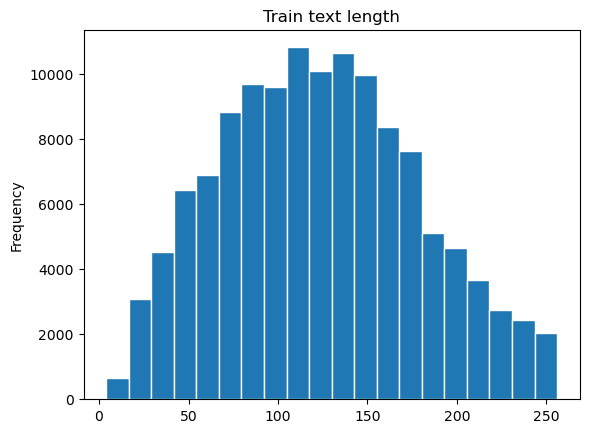

In [9]:
train_df.text.map(len).plot.hist(bins=20, edgecolor='white')
plt.title('Train text length')
plt.show()

### Pré-traitements

In [10]:
def delete_punctuation(text):
    punctuation = r"[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~\n\t]"
    text = re.sub(punctuation, " ", text)
    text = re.sub('( )+', ' ', text)
    return text

def replace_maj_word(text):
    token = '<MAJ>' # mot pour remplacer les mots en majuscules
    return ' '.join([w if not w.isupper() else token for w in delete_punctuation(text).split()])

def delete_digit(text):
    return re.sub('[0-9]+', '', text)

def first_line(text):
    return re.split(r'[.!?]', text)[0]

def last_line(text):
    if text.endswith('\n'): text = text[:-2]
    return re.split(r'[.!?]', text)[-1]

def delete_balise(text):
    return re.sub("<.*?>", "", text)

def stem(text):
    stemmer = EnglishStemmer()
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = " ".join(stemmed_tokens)
    return stemmed_text

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_text = " ".join(lemmatized_tokens)
    return lemmatized_text

### BoW

In [11]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_df.text)
print('Vocabulary size :', len(vectorizer.vocabulary_))

Vocabulary size : 51047


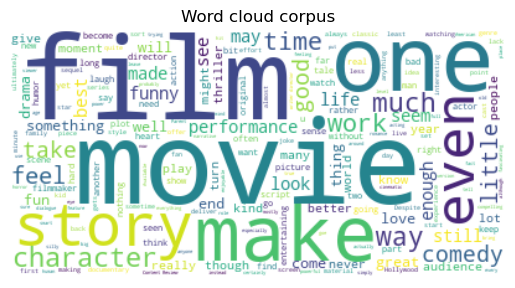

In [12]:
wc = WordCloud(background_color='white').generate(' '.join(train_df.text))
plt.title('Word cloud corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

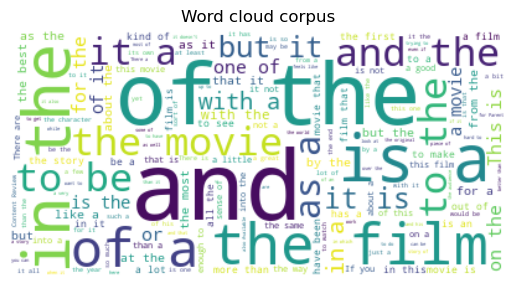

In [13]:
wc = WordCloud(background_color='white', stopwords='english').generate(' '.join(train_df.text))
plt.title('Word cloud corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

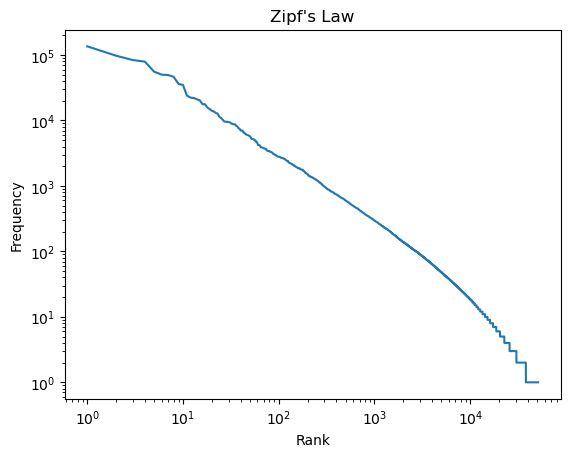

In [14]:
corpus_clean = ' '.join(train_df.text.map(delete_punctuation)).lower()
word_counts = Counter(corpus_clean.split())
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
word_freqs = [word_counts[w] for w in sorted_words]
ranks = range(1, len(sorted_words) + 1)

plt.title('Zipf\'s Law')
plt.plot(ranks, word_freqs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

In [33]:
def TfIdfClassification(vectorizer, train_df, test_df, clf, clf_args):
    X_train = vectorizer.fit_transform(train_df.text)
    X_test = vectorizer.transform(test_df.text)

    y_train = train_df.label_id
    y_test = test_df.label_id

    model = multiclass.OneVsRestClassifier(clf(**clf_args))
    model.fit(X_train, y_train)
    print(model)
    
    y_train_pred = model.predict(X_train)
    report = metrics.classification_report(y_train, y_train_pred)
    print('============= Train classification report =============')
    print(report)
    
    y_pred = model.predict(X_test)
    report = metrics.classification_report(y_test, y_pred)
    print('============= Test classification report =============')
    print(report)
    
    labels = np.unique(y_test)
    plt.figure(figsize=(8, 8))
    plt.imshow(metrics.confusion_matrix(y_test, y_pred), cmap='Blues')
    plt.axis('off')
    plt.show()

OneVsRestClassifier(estimator=LogisticRegression())
============= Train classification report =============
              precision    recall  f1-score   support

           0       0.67      0.62      0.64      1600
           1       0.59      0.76      0.66      1600
           2       0.54      0.44      0.48      1600
           3       0.65      0.45      0.53      1600
           4       0.65      0.57      0.60      1600
           5       0.62      0.70      0.66      1600
           6       0.60      0.75      0.67      1600
           7       0.60      0.76      0.67      1600
           8       0.49      0.55      0.52      1600
           9       0.65      0.56      0.60      1600
          10       0.57      0.71      0.63      1600
          11       0.64      0.91      0.75      1600
          12       0.62      0.40      0.49      1600
          13       0.57      0.63      0.60      1600
          14       0.57      0.64      0.60      1600
          15       0.52    

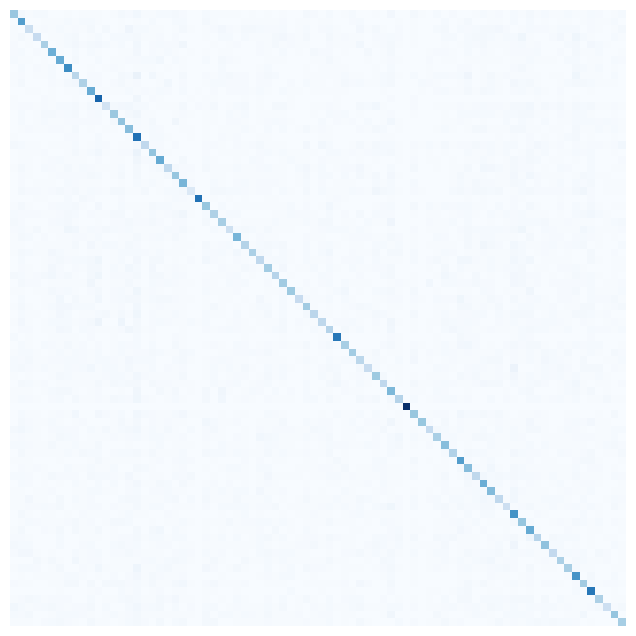

In [31]:
TfIdfClassification(TfidfVectorizer(), 
                    train_df, 
                    test_eval_df, 
                    linear_model.LogisticRegression, 
                    {'solver':'lbfgs'})

OneVsRestClassifier(estimator=LogisticRegression())
============= Train classification report =============
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1600
           1       0.86      0.94      0.90      1600
           2       0.91      0.83      0.86      1600
           3       0.94      0.84      0.89      1600
           4       0.91      0.88      0.90      1600
           5       0.82      0.88      0.85      1600
           6       0.94      0.94      0.94      1600
           7       0.76      0.87      0.81      1600
           8       0.84      0.81      0.82      1600
           9       0.96      0.87      0.91      1600
          10       0.87      0.91      0.89      1600
          11       0.77      0.98      0.86      1600
          12       0.97      0.81      0.88      1600
          13       0.81      0.86      0.84      1600
          14       0.90      0.91      0.90      1600
          15       0.81    

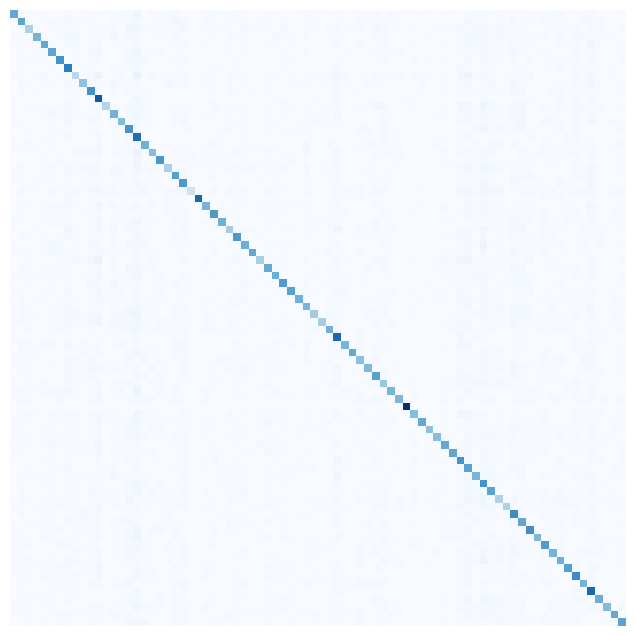

In [32]:
TfIdfClassification(TfidfVectorizer(stop_words='english', ngram_range=(1, 2)), 
                    train_df, 
                    test_eval_df, 
                    linear_model.LogisticRegression, 
                    {'solver':'lbfgs'})